In [23]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle5 as pkl
fpaths = [f'./patients_data/patient_{i}/' for i in range(1,13)]
fpathsinit = [f'./downsampled_data/patient_{i}/' for i in range(1,13)]
X = pd.DataFrame(pkl.load(open(fpathsinit[0]+"train_X.pkl", "rb")))
y = pd.DataFrame(pkl.load(open(fpathsinit[0]+"train_y.pkl", "rb")))
datasize = None  # DATA SIZE PARAM, ALL = None
X = X[:datasize]
y = y[:datasize]
wsize=15  # TUNING PARAM

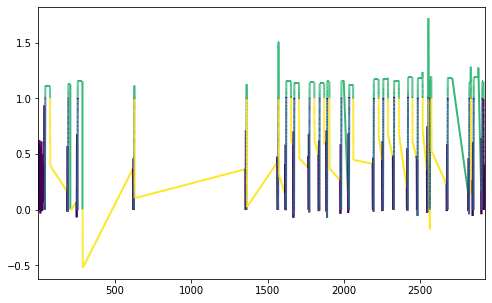

In [24]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

def get_gt(Xs, ys, lim=None):
    xplot = Xs['Time'].values[wsize+1:lim]
    yplot = Xs['Volume'].values[wsize+1:lim]
    points = np.array([xplot, yplot]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    cmap = ListedColormap(['y', 'b', 'k', 'r'])
    norm = plt.Normalize(ys["Label"].values[wsize+1:lim].min(), ys["Label"].values[wsize+1:lim].max())
    lc = LineCollection(segments, norm=norm)
    lc.set_array(ys["Label"].values[wsize+1:lim])
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    ax.set_xlim(xplot.min(), xplot.max())
    ax.set_ylim(yplot.min()-.1, yplot.max()+.1)

get_gt(X, y)

In [25]:
def embed(X1_full, y1, window_size = 5, stride = 1, full_feat=False):
    X1 = X1_full['Volume']
    samples = []
    labels = []
    for i in range(len(X1)//stride-window_size-1):
        sample = X1[stride*i:stride*i + window_size]
        if full_feat:
            sample_len = len(sample)
            sample_cat = np.empty(sample_len + 2)
            sample_cat[:sample_len] = sample
            sample_cat[sample_len] = X1_full['from_thresh'][i]
            sample_cat[sample_len + 1] = X1_full['diff'][i]
            sample = sample_cat
        samples.append(sample)
        label = y1[stride*i + window_size]
        labels.append(label)
    return np.vstack(samples), np.vstack(labels)

In [26]:
Xembed, yembed = embed(X, y['Label'], stride=1, window_size=wsize)
Xembed_feats, yembed_feats = embed(X, y['Label'], stride=1, window_size=wsize, full_feat=True)

In [27]:
from sklearn.utils.class_weight import compute_class_weight

computed_weights = compute_class_weight(class_weight='balanced',
                                       classes=np.unique(yembed),
                                       y=yembed.flatten())
computed_weights_dict = dict.fromkeys(np.unique(yembed))
for key in computed_weights_dict:
    computed_weights_dict[key] = computed_weights[key]

computed_weights_dict_sqrt = computed_weights_dict.copy()
computed_weights_dict_sqrt = {i:np.sqrt(j) for i,j in computed_weights_dict_sqrt.items()}
# total = np.sum([j for i, j in computed_weights_dict_sqrt.items()])
# computed_weights_dict_sqrt = {i:j/total for i,j in computed_weights_dict_sqrt.items()}
print(computed_weights_dict, computed_weights_dict_sqrt)

{0: 1.0715454032712917, 1: 3.7576147151898733, 2: 0.37806455464459127, 3: 6.427097428958051} {0: 1.0351547726167771, 1: 1.9384567870318579, 2: 0.6148695427849645, 3: 2.5351720708776457}


In [28]:
from sklearn.linear_model import SGDClassifier

classifiers = {
    "log": SGDClassifier(random_state=0, loss="log").fit(Xembed, np.squeeze(yembed)),
    "svm": SGDClassifier(random_state=0).fit(Xembed, np.squeeze(yembed)),
    "log-weight": SGDClassifier(random_state=0, loss="log", class_weight=computed_weights_dict).fit(Xembed, np.squeeze(yembed)),
    "svm-weight": SGDClassifier(random_state=0, class_weight=computed_weights_dict).fit(Xembed, np.squeeze(yembed)),
    "log-weight-sqrt": SGDClassifier(random_state=0, loss="log", class_weight=computed_weights_dict_sqrt).fit(Xembed, np.squeeze(yembed)),
    "svm-weight-sqrt": SGDClassifier(random_state=0, class_weight=computed_weights_dict_sqrt).fit(Xembed, np.squeeze(yembed))
}

classifiers_feats = {
    "log": SGDClassifier(random_state=0, loss="log").fit(Xembed_feats, np.squeeze(yembed_feats)),
    "svm": SGDClassifier(random_state=0).fit(Xembed_feats, np.squeeze(yembed_feats)),
    "log-weight": SGDClassifier(random_state=0, loss="log", class_weight=computed_weights_dict).fit(Xembed_feats, np.squeeze(yembed_feats)),
    "svm-weight": SGDClassifier(random_state=0, class_weight=computed_weights_dict).fit(Xembed_feats, np.squeeze(yembed_feats)),
    "log-weight-sqrt": SGDClassifier(random_state=0, loss="log", class_weight=computed_weights_dict_sqrt).fit(Xembed_feats, np.squeeze(yembed_feats)),
    "svm-weight-sqrt": SGDClassifier(random_state=0, class_weight=computed_weights_dict_sqrt).fit(Xembed_feats, np.squeeze(yembed_feats))
}

In [29]:
def get_preds(num, dsize=None, full_feat=False):  # another data size parameter. All = None
    Xs = []
    ys = []
    preds = []
    for i in range(1,num+1):
        X_session = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_X{i}.pkl", "rb")))
        y_session = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_y{i}.pkl", "rb")))
        X_session = X_session[:dsize]
        y_session = y_session[:dsize]
        X_s_test, y_s_test =  embed(
            X_session, y_session['Label'], stride=1, window_size=wsize, full_feat=full_feat)
        pred = np.zeros(len(y_s_test))
        for online_idx in tqdm(range(len(y_s_test))):
            pred[online_idx] = clf.predict(X_s_test[online_idx].reshape(1,-1))  # predict on new point
            clf.partial_fit(X_s_test[online_idx].reshape(1, -1), y_s_test[online_idx])  # fit on new
        Xs.append(X_session)
        ys.append(y_session)
        preds.append(pred)
    return Xs, ys, preds

In [30]:
class_data = {}
for key, clf in classifiers.items():
    print(f"Classifier {key}")
    class_data[key] = get_preds(1)

Classifier log


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier log-weight


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm-weight


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier log-weight-sqrt


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm-weight-sqrt


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):


In [31]:
class_data_feats = {}
for key, clf in classifiers_feats.items():
    print(f"Classifier {key}")
    class_data_feats[key] = get_preds(1, full_feat=True)

Classifier log


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier log-weight


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm-weight


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier log-weight-sqrt


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):



Classifier svm-weight-sqrt


<ipython-input-29-f924b5297b09>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for online_idx in tqdm(range(len(y_s_test))):


In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

def print_stats(y_test, preds):
    print("MSE:", mean_squared_error(y_test, preds))
    print("acc:", accuracy_score(y_test, preds))
    class_acc_list = []
    for label in np.unique(y_test):
        pred_idx = np.where(preds == label)
        class_acc = accuracy_score(y_test[pred_idx], preds[pred_idx])
        class_acc_list.append(class_acc)
        print(f"class {label} acc:", class_acc)
    print("avg class acc (unweighted):", sum(class_acc_list) / len(class_acc_list))

In [33]:
for model, clfdata in class_data.items():
    print(f"Model {model}")
    print_stats(clfdata[1][0][wsize+1:].values.flatten(), clfdata[2][0].flatten())

Model log
MSE: 0.11219362466463553
acc: 0.9626665454049383
class 0 acc: 0.9598976251017932
class 1 acc: 0.6191926884996192
class 2 acc: 0.9929075172303253
class 3 acc: 0.8727034120734908
avg class acc (unweighted): 0.8611753107263072
Model svm
MSE: 0.09426583602382793
acc: 0.9701923514164885
class 0 acc: 0.9752807461646931
class 1 acc: 0.7011788826242953
class 2 acc: 0.9957016028602418
class 3 acc: 0.7888446215139442
avg class acc (unweighted): 0.8652514632907935
Model log-weight
MSE: 0.186576326679096
acc: 0.9471829384748306
class 0 acc: 0.9613466334164589
class 1 acc: 0.39443155452436196
class 2 acc: 0.9950048340315824
class 3 acc: 0.6088560885608856
avg class acc (unweighted): 0.7399097776333222
Model svm-weight
MSE: 0.12740439270610704
acc: 0.9592446910099586
class 0 acc: 0.9784667790542068
class 1 acc: 0.5095652173913043
class 2 acc: 0.9961293444077091
class 3 acc: 0.6943231441048034
avg class acc (unweighted): 0.7946211212395059
Model log-weight-sqrt
MSE: 0.12468737210677096
acc:

In [34]:
for model, clfdata in class_data_feats.items():
    print(f"Model {model}")
    print_stats(clfdata[1][0][wsize+1:].values.flatten(), clfdata[2][0].flatten())

Model log
MSE: 0.08787685871492884
acc: 0.963860215542722
class 0 acc: 0.9647713744361911
class 1 acc: 0.5497351383166569
class 2 acc: 0.9926750190129288
class 3 acc: 0.920876445526476
avg class acc (unweighted): 0.8570144943230632
Model svm
MSE: 0.06607248419808104
acc: 0.9751830294211268
class 0 acc: 0.982023854277024
class 1 acc: 0.6990622335890878
class 2 acc: 0.9961859643488036
class 3 acc: 0.8491773308957953
avg class acc (unweighted): 0.8816123457776777
Model log-weight
MSE: 0.16853485516802327
acc: 0.9496498567595835
class 0 acc: 0.9668147688916443
class 1 acc: 0.4122431506849315
class 2 acc: 0.9951294127118303
class 3 acc: 0.6290025763709974
avg class acc (unweighted): 0.7507974771648509
Model svm-weight
MSE: 0.08984357237051521
acc: 0.9671229139193306
class 0 acc: 0.9864108155255125
class 1 acc: 0.561050061050061
class 2 acc: 0.9962951030927835
class 3 acc: 0.7696562623468984
avg class acc (unweighted): 0.8283530605038139
Model log-weight-sqrt
MSE: 0.093822472829794
acc: 0.96

In [35]:
def get_plots(Xs, ys, preds, lim=1000):  #another size param. Lim=None for full plot
    for i in range(len(Xs)):
        xplot = Xs[i]['Time'][wsize+1:lim]
        yplot = Xs[i]['Volume'][wsize+1:lim]
        points = np.array([xplot, yplot]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        fig, ax = plt.subplots(1,1, figsize=(8,5))
        cmap = ListedColormap(['k', 'r', 'g', 'b'])
        norm = plt.Normalize(preds[i][:lim].min(), preds[i][:lim].max())
        lc = LineCollection(segments, norm=norm)
        lc.set_array(preds[i][:lim])
        lc.set_linewidth(2)
        line = ax.add_collection(lc)

        ax.set_xlim(xplot.min(), xplot.max())
        ax.set_ylim(yplot.min()-.1, yplot.max()+.1)
        plt.show()

Model log


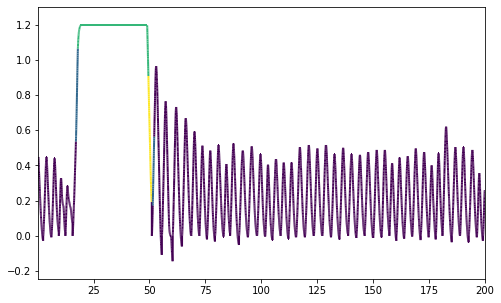

Model svm


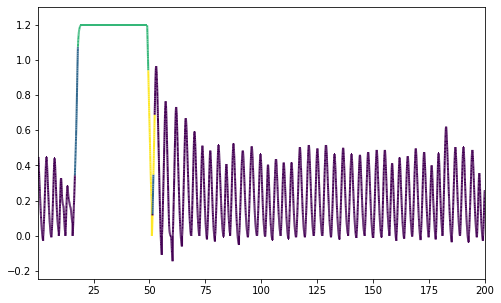

Model log-weight


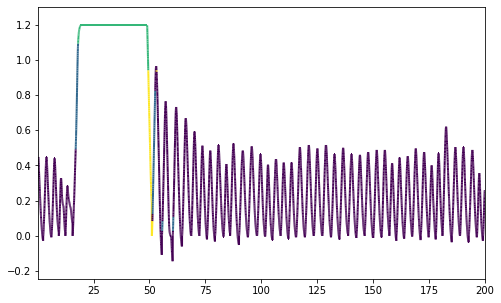

Model svm-weight


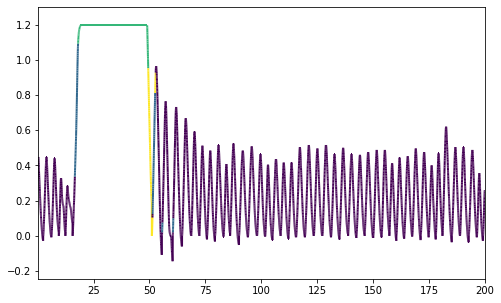

Model log-weight-sqrt


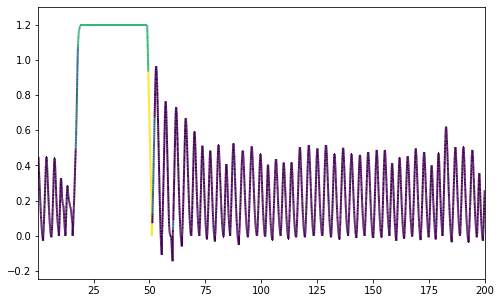

Model svm-weight-sqrt


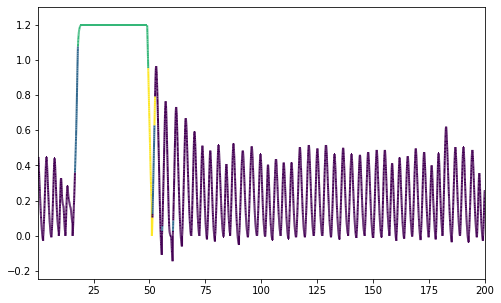

In [43]:
for model, clfdata in class_data.items():
    print(f"Model {model}")
    get_plots(*clfdata, 10000)

Model log


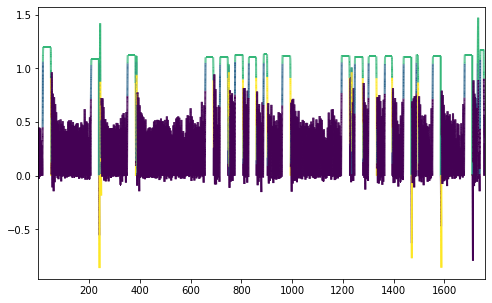

Model svm


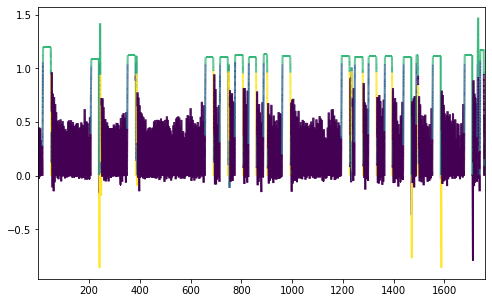

Model log-weight


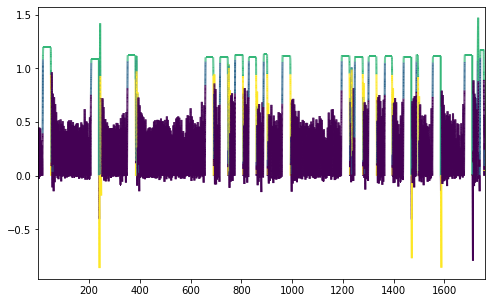

Model svm-weight


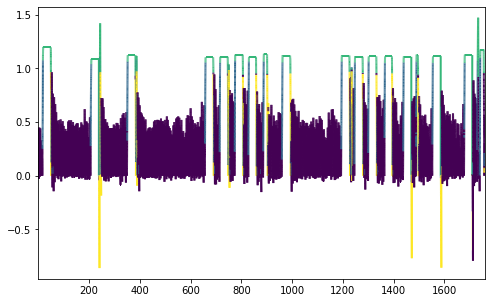

Model log-weight-sqrt


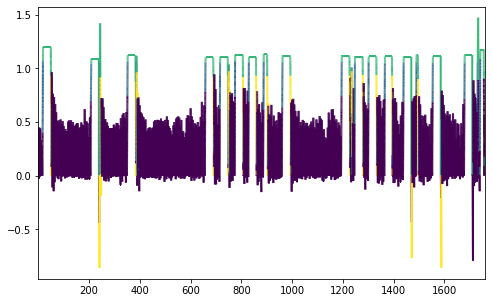

Model svm-weight-sqrt


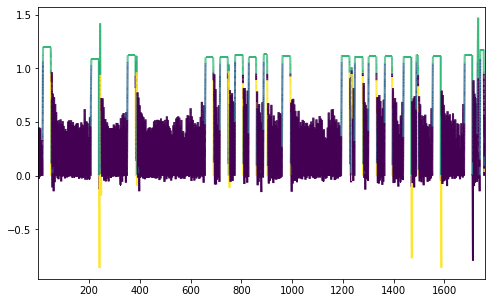

In [37]:
for model, clfdata in class_data_feats.items():
    print(f"Model {model}")
    get_plots(*clfdata, None)

In [38]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(X_test, y_test, y_score, n_classes, figsize=(17, 6), title="default"):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        y_test_oneVall = (y_test[wsize+1:]==i).astype(int)
        y_score_oneVall = (y_score==i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y_test_oneVall, y_score_oneVall)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC {title}')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

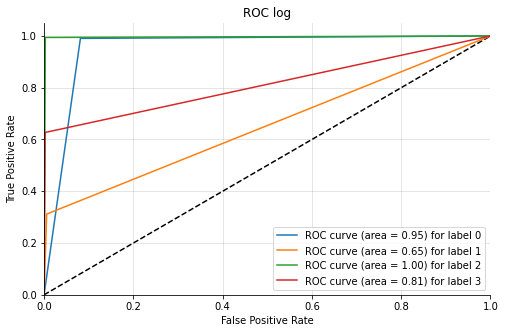

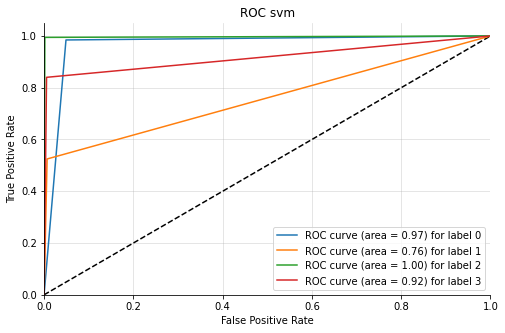

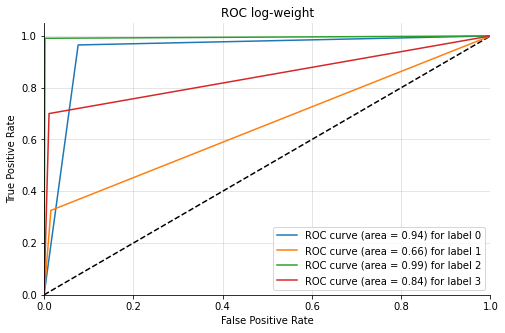

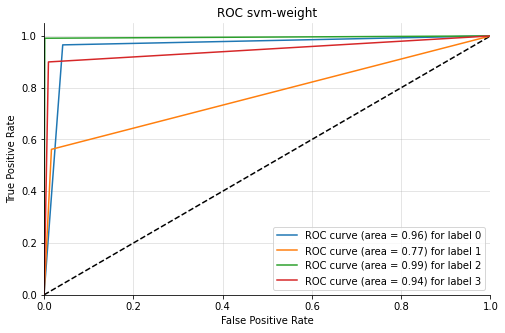

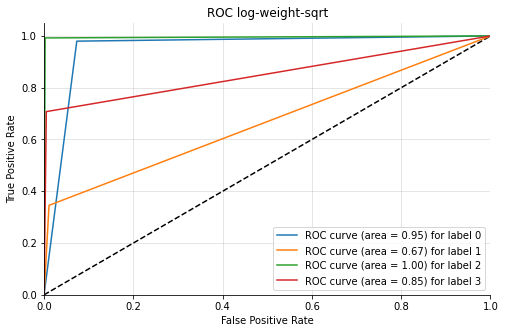

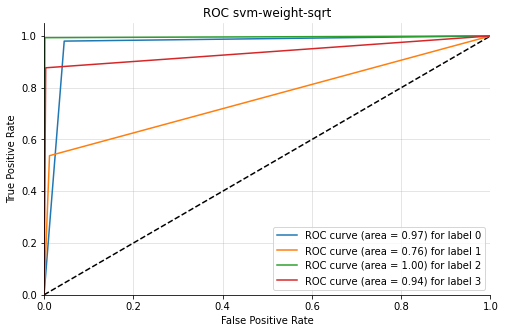

In [39]:
import seaborn as sns
for model, clfdata in class_data.items():
    plot_multiclass_roc(
        clfdata[0][0], clfdata[1][0], clfdata[2][0], n_classes=4, figsize=(8,5), title=model)

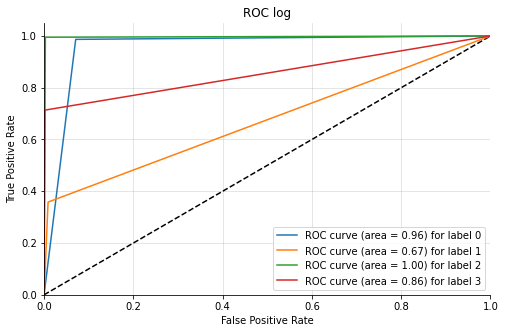

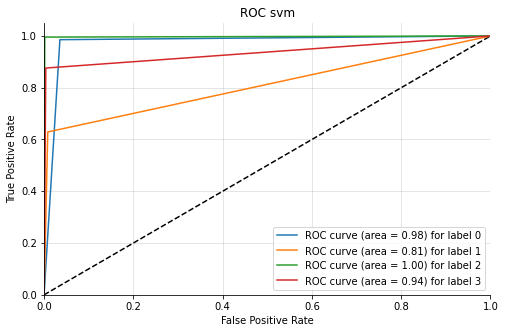

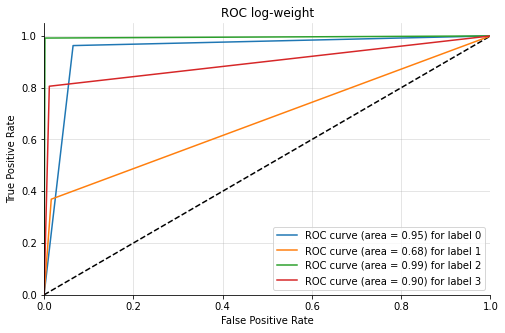

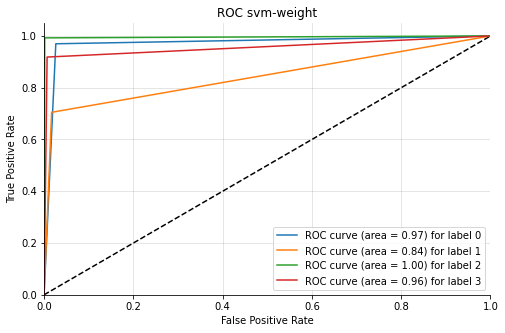

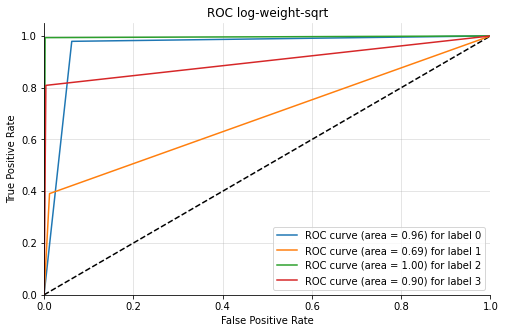

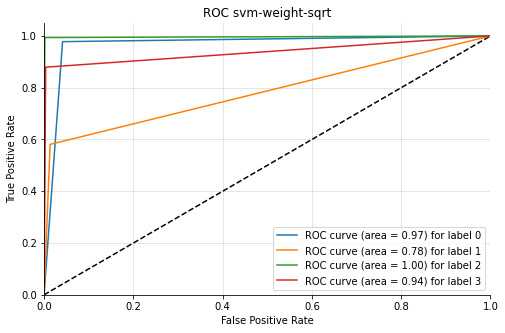

In [40]:
for model, clfdata in class_data_feats.items():
    plot_multiclass_roc(clfdata[0][0], clfdata[1][0], clfdata[2][0], n_classes=4, figsize=(8,5), title=model)

In [41]:
def baseline():
    X = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_X1.pkl", "rb")))
    y = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_y1.pkl", "rb")))
    pred = (X.iloc[:,2]>0).astype(int)
    pred *= 2 # Classes 0 (under thresh) and 2 (above thresh)
    return X, y, pred

In [42]:
X, y, pred = baseline()

In [ ]:
def get_gt(Xs, ys, lim=1000):
    xplot = Xs['Time'].values[wsize+1:lim]
    yplot = Xs['Volume'].values[wsize+1:lim]
    points = np.array([xplot, yplot]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    cmap = ListedColormap(['y', 'b', 'k', 'r'])
    norm = plt.Normalize(ys["Label"].values[wsize+1:lim].min(), ys["Label"].values[wsize+1:lim].max())
    lc = LineCollection(segments, norm=norm)
    lc.set_array(ys["Label"].values[wsize+1:lim])
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    ax.set_xlim(xplot.min(), xplot.max())
    ax.set_ylim(yplot.min()-.1, yplot.max()+.1)

In [ ]:
get_gt(X,y,None)

In [ ]:
get_plots([X], [y], [pred[wsize+1:]], None)

In [ ]:
plot_multiclass_roc(X, y, pred[wsize+1:], n_classes=4, figsize=(8,5), title="Baseline")